<div style="text-align: center; font-weight: bold; font-size: 40px; padding: 10px;">
    Text Mining Project: Stock Sentiment Analysis
</div>
<div style="text-align: center; font-weight: bold; font-size: 25px; padding: 10px;">
    Data Exploration + Data Preprocessing
</div>
<div style="text-align: center; font-weight: bold; font-size: 20px; padding: 10px;">
    Group 21
</div>

# 0. Imports

In [70]:
# !pip install emoji
# !pip install langdetect
# !pip install wordcloud
# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')
# !pip install gensim
# !pip install langdetect

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import json
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
import emoji
from langdetect import detect, detect_langs, LangDetectException

import torch
import tensorflow as tf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
)
from sklearn.feature_selection import SelectKBest, chi2

# Other classificaton models explored
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import itertools

from gensim.models import Word2Vec
import gensim.downloader

In [9]:
from functions.utils import *

In [ ]:
# df_train = pd.read_csv('/content/drive/My Drive/train.csv')
# df_test = pd.read_csv('/content/drive/My Drive/test.csv')
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
df_train.head(10)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,0
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",0
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,0
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,0
5,$FTI - TechnipFMC downgraded at Berenberg but called Top Pick at Deutsche Bank https://t.co/XKcPDilIuU,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7Fv1ZiFZBS,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone estimate after Foxconn delay https://t.co/rlnEwzlzzS,0


In [13]:
df_train["named_label"] = df_train["label"].apply(lambda x: "Neutral (2)" if x == 2 else "Bullish (1)" if x == 1 else "Bearish (0)")

# 1. Data Exploration

In [14]:
print(f"Number of rows in train dataset: {len(df_train)}")
print(f"Number of rows in test dataset: {len(df_test)}")

Number of rows in train dataset: 9543
Number of rows in test dataset: 2388


## 1.1 Label (Dependent Feature)

> ``0 = Bearish``, ``1 = Bullish``, ``2 = Neutral``
> - **Bullish**: "believes that the price of one or more securities or indexes will rise"
> - **Bearish**: "believes prices will go down"

In [15]:
(df_train['named_label']).unique()

array(['Bearish (0)', 'Bullish (1)', 'Neutral (2)'], dtype=object)

In [16]:
df_train['label'].describe().round(3)

count    9543.000
mean        1.496
std         0.743
min         0.000
25%         1.000
50%         2.000
75%         2.000
max         2.000
Name: label, dtype: float64

> Most frequent label is ``Neutral (2)``. </br>
> Imbalanced, as Neutral is about 3 times more than the other 2.

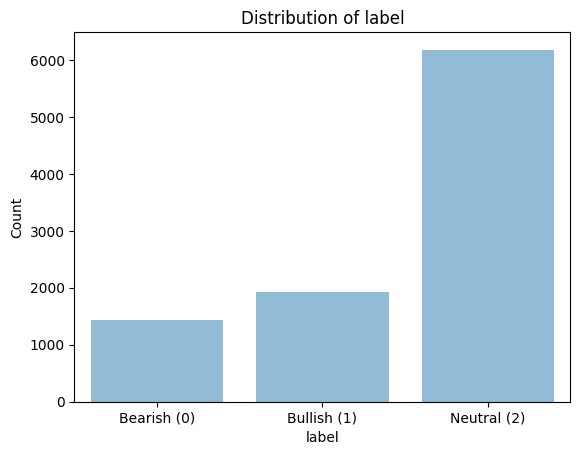

In [17]:
# Visualize distribution of labels
sns.countplot(data=df_train, x='named_label', color='#87bde1')
plt.title("Distribution of label")
plt.xlabel("label")
plt.ylabel("Count")
plt.show()

## 1.2 Text (Independent feature)

In [18]:
# Checking examples of different tweets for each label
for label in df_train["named_label"].unique():
    print(f"Example of 5 tweets with label {label}:")
    print(df_train[df_train["named_label"] == label].text.sample(5, random_state=1).values)
    print("\n")

Example of 5 tweets with label Bearish (0):
["Why China's coronavirus is more dangerous for the global economy than SARS was in 2003 https://t.co/diuqsVLFOD via @BW"
 'The head of loan trading at UBS was terminated after engaging in an allegedly improper transaction https://t.co/3uMpB70a99'
 'Walmart Inc.’s Jet subsidiary is ending its fresh-food delivery business just a year after introducing the service… https://t.co/MpzLxKX3cW'
 "The coronavirus is a 'black swan' for oil and energy markets, says Ned Davis Research https://t.co/pm0Dv01lGW"
 'Kellogg -6% after profit outlook disappoints']


Example of 5 tweets with label Bullish (1):
['Analyst: AT&T Is The Top Telecom Pick For 2020'
 'Rally goes on as China cuts U.S. tariffs'
 'U.S. stocks are 📈 https://t.co/2cVbN4AIF4 https://t.co/iAQJgLcbR6'
 "Stifel Upgrades Wendy's, Bullish On Breakfast And Digital Prospects"
 'Toyota in Growth Mode Defies Slowdown in Global Vehicle Demand']


Example of 5 tweets with label Neutral (2):
['Total: F

### Null and Duplicate Values

In [19]:
print(f"Number of null values in 'text': {df_train['text'].isnull().sum()}")
print(f"Number of duplicated texts in df_train: {df_train.text.duplicated().sum()}")

Number of null values in 'text': 0
Number of duplicated texts in df_train: 0


### Word count in text

> Create a ``word_count`` column:

In [20]:
df_train['word_count']  = df_train['text'].apply(lambda x: len(str(x).split(" ")))
df_train[['text','word_count']].head(5)

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,10
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",14
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,7
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,10


In [21]:
df_train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

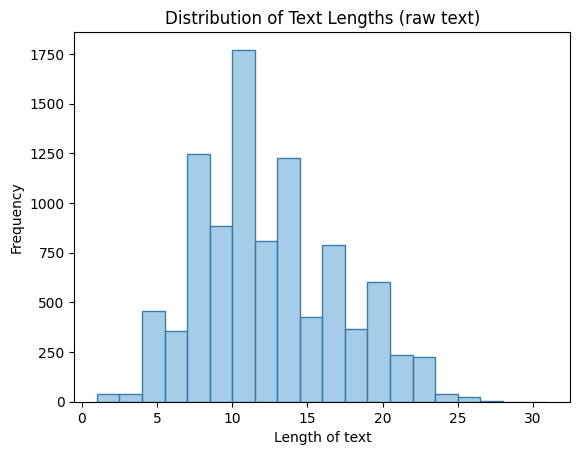

In [22]:
#Plot distribution of text length
sns.histplot(df_train['word_count'], bins=20, color='#87bde1',edgecolor='#3a7ca9')
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

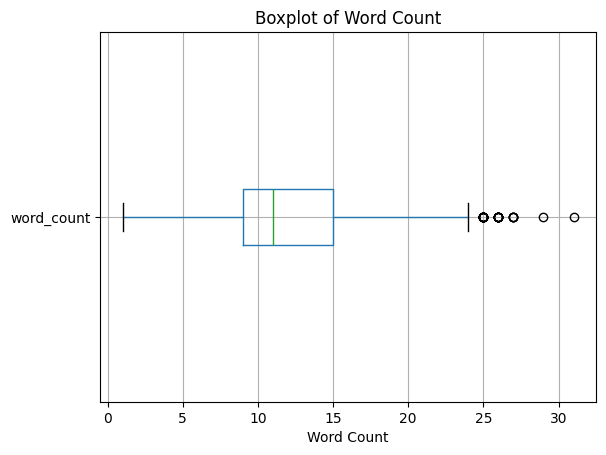

In [23]:

df_train.boxplot(column='word_count', vert=False)
plt.title("Boxplot of Word Count")
plt.xlabel("Word Count")
plt.show()


> The word count distribution is similar across labels.

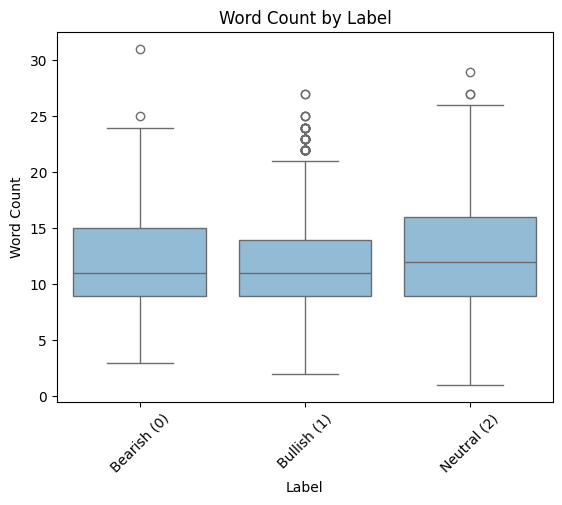

In [24]:
# Word count distribution across labels
sns.boxplot(x="named_label", y="word_count", data=df_train,  color='#87bde1')
plt.title("Word Count by Label")
plt.xlabel("Label")
plt.ylabel("Word Count")
plt.xticks(rotation=45)
plt.show()


In [25]:
# Check the tweets with only one word
df_train[df_train['word_count']==1].head()

,text,label,named_label,word_count
1858,SASA聚酯选用英威达PTA技术,2,Neutral (2),1
3943,:),2,Neutral (2),1
3948,@TicToc,2,Neutral (2),1
4360,Damn,2,Neutral (2),1
4440,F5,2,Neutral (2),1


> Some of the outliers seem to be non-informative with unusual puts or unusual calls.

In [26]:
# Check the tweets with more than 24 words
df_train[df_train['word_count']>24].head()

,text,label,named_label,word_count
342,Upgrades 11/25: $ARWR $CACI $CF $DECK $DKS $ENR $EQM $ETRN $FE $HAS $HLX $JD $KIM $LYFT $NTR $NVDA $ORAN $PROS $SNAP $WEN $WING $WRI $ZS,1,Bullish (1),25
606,"It may seem odd for the Federal Reserve to buy ETFs, but it's not unprecedented for a central bank -œ Japan did it f… https://t.co/Tm7u3av8zC",2,Neutral (2),25
1158,"$TCCO insane, halted again...... Just 1.85M shares float, exaclty like $MYSZ lets see if we get good news to see also a big pop. Im long.",2,Neutral (2),26
1230,"Amazon Announces First-Ever ‘Amazon Future Engineer Teacher of the Year Awards,’ Awarding Seven All-Star Teachers $25,000 Prize Packages for Exemplar Work with Students Across the Country",2,Neutral (2),26
1455,Executives at SoftBank are looking for a way to reduce the size of a $3 billion offer for WeWork stock as part of i… https://t.co/4kqz2W0yhz,2,Neutral (2),25


In [27]:
print(f"Number of outliers with more than 24 words: {len(df_train[df_train['word_count'] > 24])}")
print(f"Label count for outliers with more than 24 words:\n{df_train[df_train['word_count'] > 24]['named_label'].value_counts()}")

Number of outliers with more than 24 words: 32
Label count for outliers with more than 24 words:
named_label
Neutral (2)    25
Bullish (1)     5
Bearish (0)     2
Name: count, dtype: int64


In [28]:
print(f"Number of outliers with less than 2 words: {len(df_train[df_train['word_count'] <2])}")
print(f"Label count for outliers with less than 2 words:\n{df_train[df_train['word_count']<2]['named_label'].value_counts()}")

Number of outliers with less than 2 words: 28
Label count for outliers with less than 2 words:
named_label
Neutral (2)    28
Name: count, dtype: int64


### Frequency of each word

> Most frequent words are "connecting words" (stopwords)

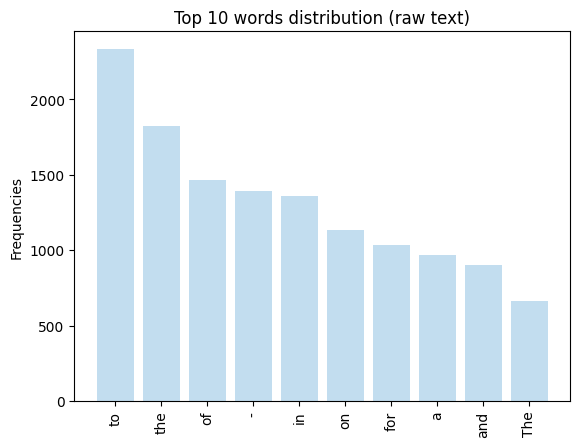

In [29]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5, color='#87bde1')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Top 10 words distribution (raw text)')
plt.xticks(rotation=90)
plt.show()

### Word cloud from raw text

> There are a lot of links ("https") and stock and marketscreener are also common words

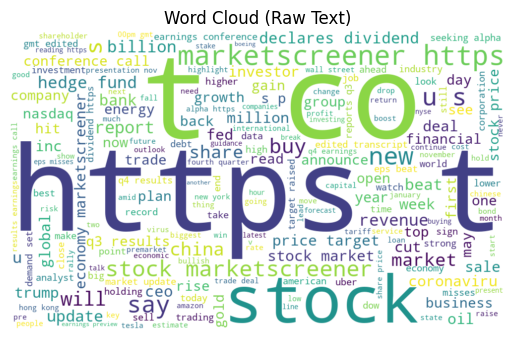

In [30]:
# 🌥️ Create a word cloud from the raw text
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=1000, height=600, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

### Language detection

In [31]:
def language_detection(text):
    try:
        return detect(text)
    except LangDetectException:
        return "Unable to detect language"

In [32]:
df_train['language'] = df_train['text'].apply(language_detection)

In [33]:
df_train[['text','language']].head()

,text,language
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,en
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,en
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",en
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,en
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,da


Top 10 languages detected:

In [34]:
freq = pd.Series(df_train['language']).value_counts()
freq.sort_values(ascending=False)[:10]

language
en    8856
ca     109
de     103
es      86
fr      84
sv      59
da      45
nl      35
no      32
it      29
Name: count, dtype: int64

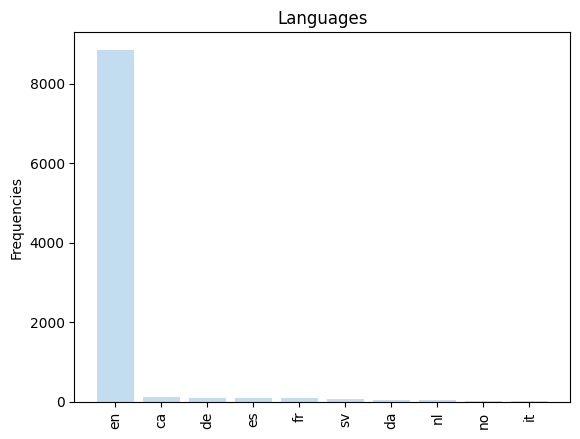

In [35]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5, color='#87bde1')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Languages')
plt.xticks(rotation=90)
plt.show()

> It seems that there are tweets in english being classified as non-english. Let's run this again after we've removed special characters.


In [36]:
df_train[df_train['language'] != 'en'][['text','language']]

,text,language
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,da
5,$FTI - TechnipFMC downgraded at Berenberg but called Top Pick at Deutsche Bank https://t.co/XKcPDilIuU,de
7,$GM: Deutsche Bank cuts to Hold https://t.co/7Fv1ZiFZBS,de
24,$TWLO - Twilio gets Street-low target on virus risk https://t.co/Ky3d8DxnjX,af
70,Grubhub gains a bear on margin view,af
...,...,...
9463,Vivus shares rise on bulimia data for Qsymia,et
9465,"VKTX, JKS among premarket gainer",no
9467,Volkswagen +2% after strong deliveries report,da
9486,$SCANX: Early premarket gappers https://t.co/atMuPDtoLX,no


### Special Characters

In [40]:
figure_dict = {
    # "$words mentions": r'\$[A-Za-z]{1,5}(?:pr[A-Z])?',
    # "$numbers mentions": r'\$\d+(?:\.\d+)?',
    "Negative number mentions": r'(?<![a-zA-Z0-9])-\d+(?:\.\d+)?\b(?!\d)',
    "Positive percentage mentions": r'(?<!-)\b\d+(?:\.\d+)?%',
    # "Dates mentions": r'\b\d{1,2}[-/\.]\d{1,2}[-/\.]\d{2,4}\b|'  # 12/05/2024 or 12.05.2024
    # r'\b(?:\d{1,2}\s)?(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\.?\s\d{2,4}\b|'  # 12 Jan 2024
    # r'\b\d{1,2}[-](?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*[-]\d{2,4}\b|'  # 12-Jan-2024
    # r'\b(?:Mon|Tues|Wed|Thu|Thurs|Fri|Sat|Sun|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday)\b|'  # weekdays
    # r'\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\.?\b',
    # "Time mentions": r'\b\d{1,2}(:\d{2})?\s?(am|pm|AM|PM)?(\s?[A-Z]{2,4})?\b',
    # "Positive number mentions": r'(?<!-)\b\d{1,3}(?:,\d{3})*(?:\.\d+)?\b',
    # "Links mentions": r'https://[^\s"]+',
    # "Unicode mentions": r'[\U00010000-\U0010FFFF]',
    # "User mentions (@user)": r'@[\w_]+',
    # "Hashtag mentions (#hashtag)": r'#\w+',
    "Multi-exclamation mentions": r'(\!)\1+',
    # "Exclamation mentions": r'(\!)+',
    # "Multi-stop mentions": r'(\.)\1+',
    # "Multi-question mentions": r'\?{2,}',
    # "Question mentions": r'\?+',
}

Here we present combinations of characters that seem to be more present in certain labels:
- Negative numbers (ex: "-10") --> most are in Bearish (0)   
- Positive percentages (ex: "5%") --> most are in Bullish (1)
- Multi-exclamations (ex: "!!!") --> most are in Bullish (1)

Tweets with NEGATIVE NUMBER MENTIONS
Total 65 (0.68%)
Examples:

Text: $NFLX (-0.7% pre) Wells Fargo Downgrades Netflix (NFLX) to Underperform on Free Cash Flow Concerns, Still Sees Acqu… https://t.co/D9EZor24lS
Label: Bearish (0)
------------------------------------------------------------
Text: $VRNS - Varonis -6% on wider-than-expected loss forecast https://t.co/bI9ePk3ikY
Label: Bearish (0)
------------------------------------------------------------
Text: $FL - Foot Locker -5% after Telsey warning https://t.co/Zy2fcVSr5c
Label: Bearish (0)
------------------------------------------------------------
Text: Fed Unveils Major Expansion of Market -2- #economy #MarketScreener https://t.co/Flf1QDVuCH https://t.co/yzwBwPp89h
Label: Neutral (2)
------------------------------------------------------------
Text: $SEAC (-20.1% pre) SeaChange International Reports Fourth Quarter and Fiscal Year 2020 Financial Results - Accesswi… https://t.co/ZvnpKTeTnm
Label: Bearish (0)
---------------------

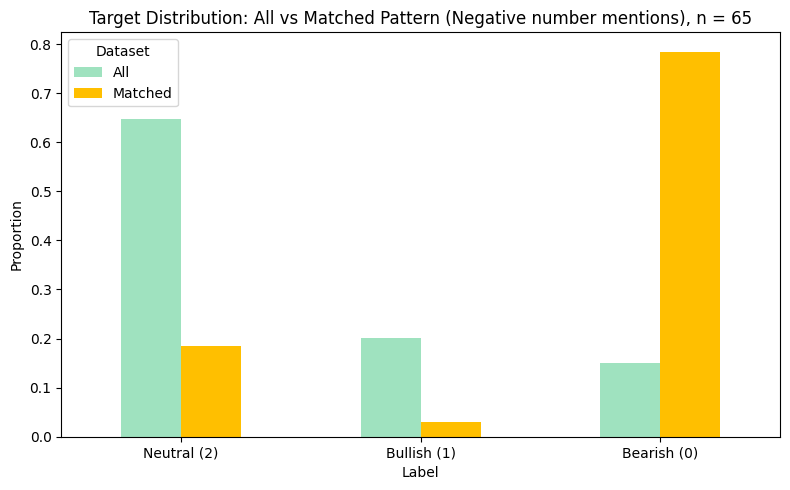

____________________________________________________________________________________________________


Tweets with POSITIVE PERCENTAGE MENTIONS
Total 808 (8.47%)
Examples:

Text: 45% of Airline Loyalty Program Members Don't Know How to Use Their Rewards
Label: Neutral (2)
------------------------------------------------------------
Text: Disney Q1 Revenue Up 36%
Label: Bullish (1)
------------------------------------------------------------
Text: $DRI: Darden Restaurants provides COVID-19 update, reports quarter-to-date Q4 comps of -39.1% https://t.co/swpeTULQ6d
Label: Bearish (0)
------------------------------------------------------------
Text: Aravive rockets 263% premarket on promise of lead candidate
Label: Bullish (1)
------------------------------------------------------------
Text: CymaBay shares fall 77% on halted trial
Label: Bearish (0)
------------------------------------------------------------


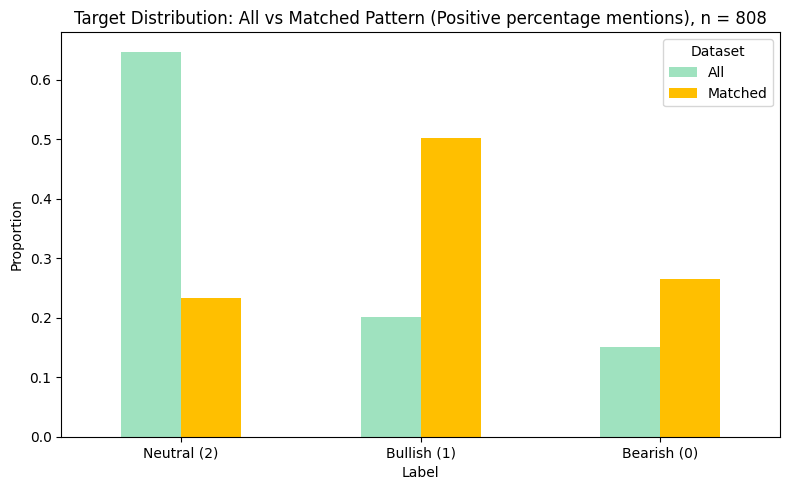

____________________________________________________________________________________________________


Tweets with MULTI-EXCLAMATION MENTIONS
Total 20 (0.21%)
Examples:

Text: $MYOV here we go !!
Label: Neutral (2)
------------------------------------------------------------
Text: $PHUN news out !!!!
Label: Neutral (2)
------------------------------------------------------------
Text: $SES BINGO !!!!!!!!
Label: Neutral (2)
------------------------------------------------------------
Text: $MYO off $SONN low float mania is back !!!
Label: Bullish (1)
------------------------------------------------------------
Text: $OPK a great chart for technical traders..... Frost on the move !! https://t.co/EVpm3juHsb
Label: Bullish (1)
------------------------------------------------------------


c:\Users\ritaw\Desktop\NOVA\Text Mining\Text_Mining_24_25\functions\utils.py:104: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_col].str.contains(pattern, regex=True)


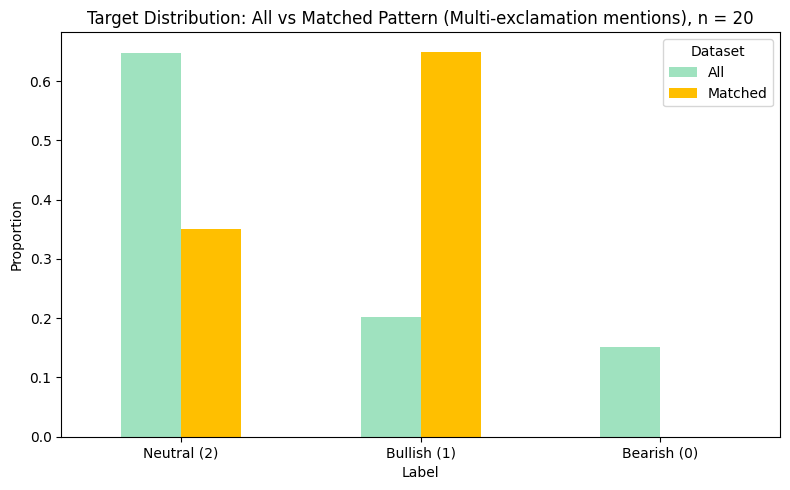

____________________________________________________________________________________________________




In [41]:
for pattern_name, pattern in figure_dict.items():
    analyze_regex_mentions(df_train, text_col="text", target_col="named_label", pattern=pattern, pattern_name=pattern_name)
    print("_"*100)
    print("\n")

#### Hashtags

In [42]:
extract_hashtags(df_train)

,text,hashtags
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,[]
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,[]
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",[]
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,[]
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,[]


In [43]:
all_hashtags = sum(df_train['hashtags'].tolist(), [])
hashtag_counts = Counter(all_hashtags)

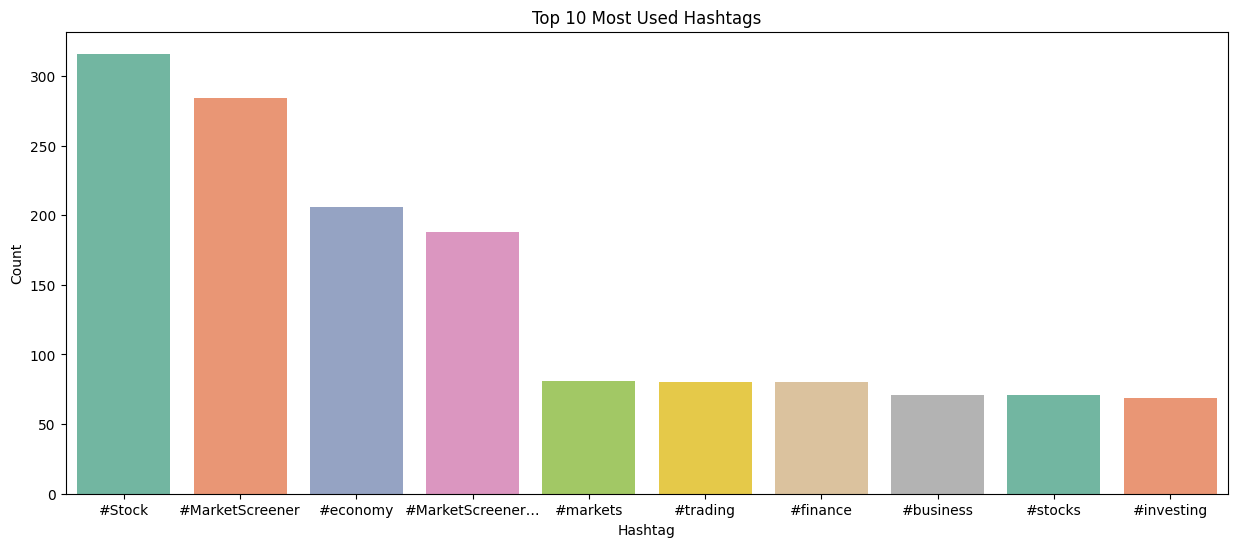

In [44]:
colors = sns.color_palette("Set2", 10)

dollar_df = pd.DataFrame(hashtag_counts.most_common(10), columns=['hashtag', 'count'])

plt.figure(figsize=(15,6))
sns.barplot(data=dollar_df, x='hashtag', y='count', hue='hashtag', palette=colors, dodge=False)
plt.title('Top 10 Most Used Hashtags')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.legend([], [], frameon=False)  # This hides the legend
plt.show()


#### Dollar Ticker $

In [45]:
df_train['dollar_symbol'] = df_train['text'].apply(extract_dollar)
df_train[['text', 'dollar_symbol']].head()

,text,dollar_symbol
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,[$BYND]
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,"[$CCL, $RCL]"
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",[$CX]
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,[$ESS]
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,[$FNKO]


In [46]:
all_dollar = sum(df_train['dollar_symbol'].tolist(), [])  # flatten list of lists
dollar_count = Counter(all_dollar)

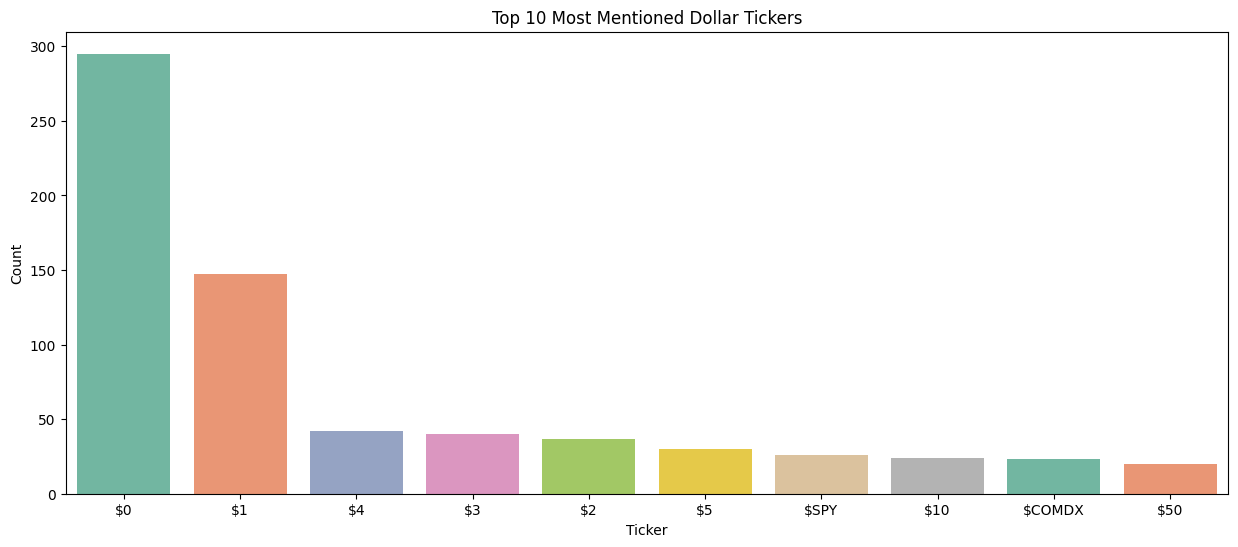

In [71]:
colors = sns.color_palette("Set2", 10)

dollar_df = pd.DataFrame(dollar_count.most_common(10), columns=['ticker', 'count'])

plt.figure(figsize=(15,6))
sns.barplot(data=dollar_df, x='ticker', y='count', hue='ticker', palette=colors, dodge=False)
plt.title('Top 10 Most Mentioned Dollar Tickers')
plt.xlabel('Ticker')
plt.ylabel('Count')
plt.legend([],[], frameon=False)

> Mostly dollar ammounts it seems. Let's check without the numbers.


In [48]:
filtered_dollar = [word for word in all_dollar if is_valid_ticker(word)]
filtered_dollar_count = Counter(filtered_dollar)


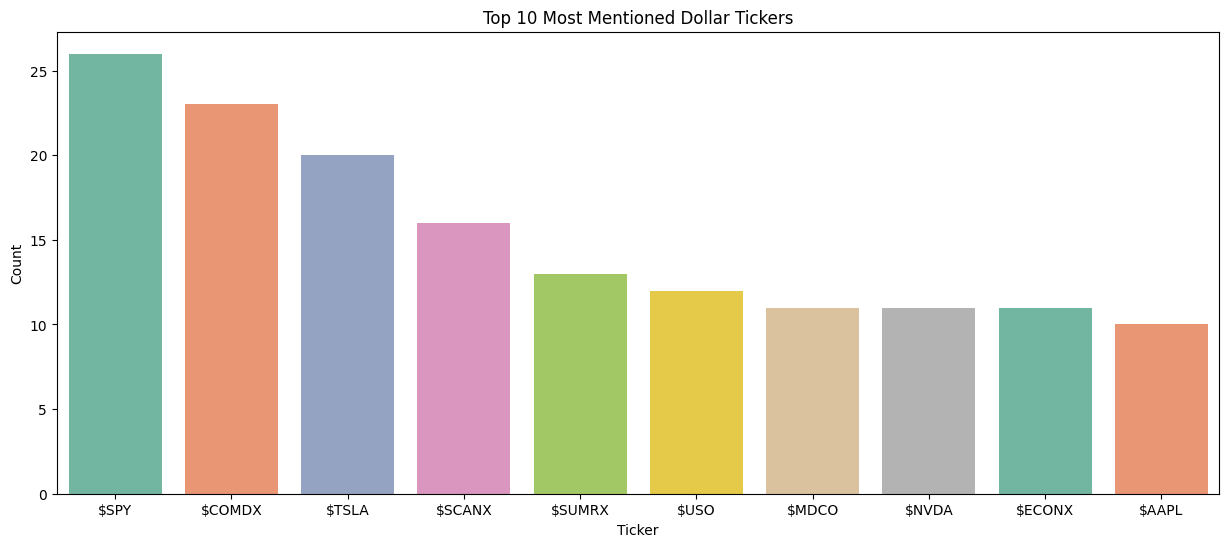

In [72]:

colors = sns.color_palette("Set2", 10)
dollar_df = pd.DataFrame(filtered_dollar_count.most_common(10), columns=['ticker', 'count'])

plt.figure(figsize=(15,6))
sns.barplot(data=dollar_df, x='ticker', y='count', hue='ticker', palette=colors, dodge=False)
plt.title('Top 10 Most Mentioned Dollar Tickers')
plt.xlabel('Ticker')
plt.ylabel('Count')
plt.legend([],[], frameon=False)
plt.show()


#### Mentions @

In [50]:
df_train['mentions'] = df_train['text'].apply(extract_mentions)

In [51]:
all_mentions = sum(df_train['mentions'].tolist(), [])
mention_counts = Counter(all_mentions)

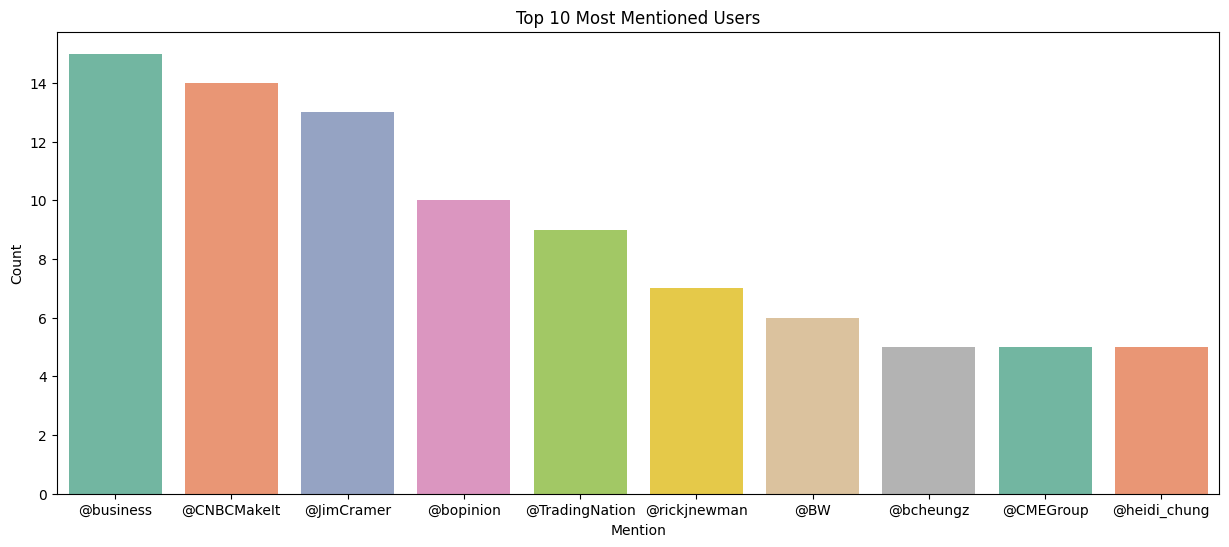

In [52]:
colors = sns.color_palette("Set2", 10)

mentions_df = pd.DataFrame(mention_counts.most_common(10), columns=['mentions', 'count'])

plt.figure(figsize=(15,6))
sns.barplot(data=mentions_df, x='mentions', y='count', hue='mentions', palette=colors, dodge=False)
plt.title('Top 10 Most Mentioned Users')
plt.xlabel('Mention')
plt.ylabel('Count')
plt.legend([],[], frameon=False)
plt.show()

### N-grams Occurence

C:\Users\ritaw\AppData\Local\Temp\ipykernel_19136\3819244046.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_df, x="count", y="bigram", palette=sns.color_palette("Set2", 10))


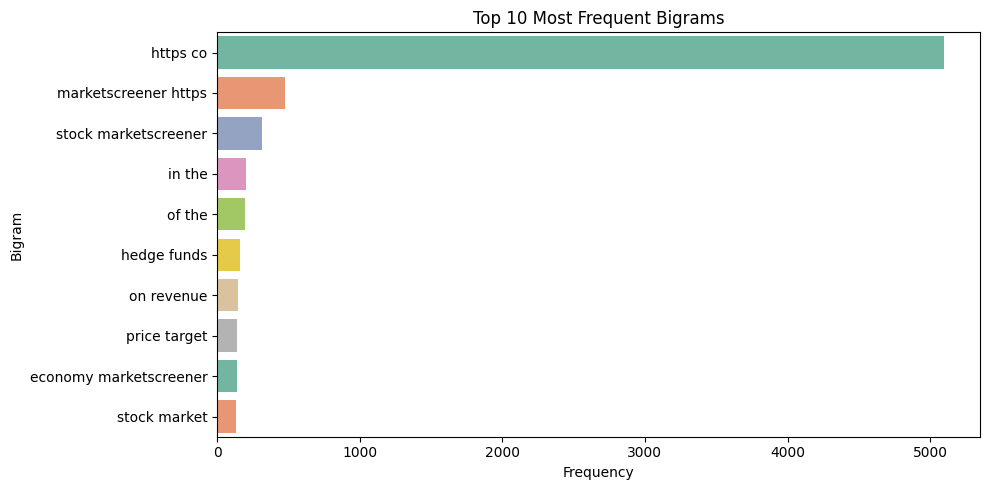

In [74]:
top_tweet_bigrams = get_top_tweet_bigrams(df_train['text'])[:10]
x, y = map(list, zip(*top_tweet_bigrams))
bigram_df = pd.DataFrame({"bigram": x, "count": y})

plt.figure(figsize=(10, 5))
sns.barplot(data=bigram_df, x="count", y="bigram", palette=sns.color_palette("Set2", 10))
plt.title("Top 10 Most Frequent Bigrams")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()


> "http co" is part of url. Ignore it for now.

C:\Users\ritaw\AppData\Local\Temp\ipykernel_19136\735182463.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_df, x="count", y="bigram", palette=sns.color_palette("Set2", 10))


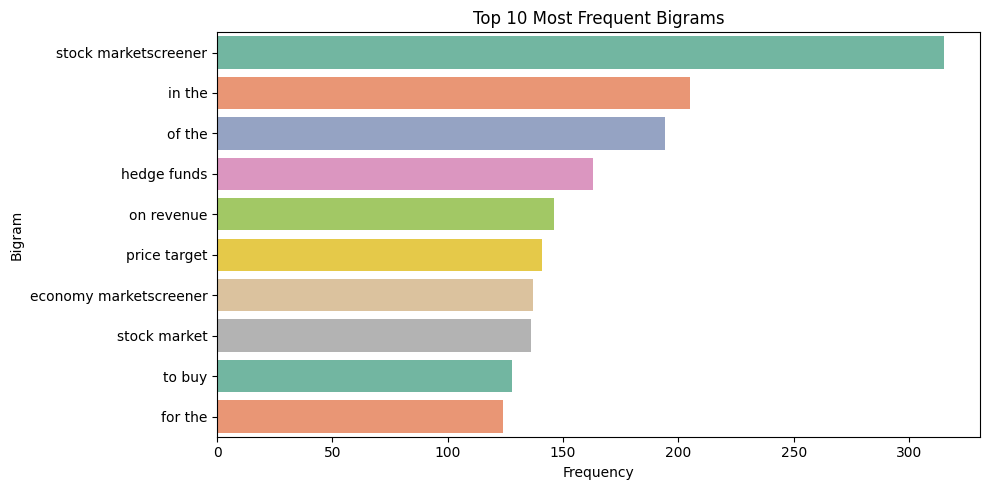

In [55]:
top_tweet_bigrams = get_top_tweet_bigrams(df_train['text'])[2:12]
x, y = map(list, zip(*top_tweet_bigrams))
bigram_df = pd.DataFrame({"bigram": x, "count": y})

plt.figure(figsize=(10, 5))
sns.barplot(data=bigram_df, x="count", y="bigram", palette=sns.color_palette("Set2", 10))
plt.title("Top 10 Most Frequent Bigrams")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()


In [57]:
df_train.drop(columns=['hashtags', 'dollar_symbol', 'mentions'], inplace=True)

## Top 10 words based on Chi-squared test

In [59]:
top_features = extract_features_chi2(df_train['text'], df_train['label'], top_features=100)

print(f"Top 10 words based on Chi-squared test:")
for feature in top_features[:10]:
    print(feature)

for feature in top_features[:10]:
    print(f"Distribution across labels for word '{feature}' (total: {df_train[df_train['text'].str.contains(feature)].shape[0]}):")
    print(f"  - Number of Bullish (1) tweets: {df_train[df_train['text'].str.contains(feature) & (df_train['label'] == 1)].shape[0]}")
    print(f"  - Number of Bearish (0) tweets: {df_train[df_train['text'].str.contains(feature) & (df_train['label'] == 0)].shape[0]}")
    print(f"  - Number of Neutral (2) tweets: {df_train[df_train['text'].str.contains(feature) & (df_train['label'] == 2)].shape[0]}")

Top 10 words based on Chi-squared test:
beats
down
raised
misses
up
bullish
downgraded
lower
after
target
Distribution across labels for word 'beats' (total: 132):
  - Number of Bullish (1) tweets: 91
  - Number of Bearish (0) tweets: 1
  - Number of Neutral (2) tweets: 40
Distribution across labels for word 'down' (total: 236):
  - Number of Bullish (1) tweets: 10
  - Number of Bearish (0) tweets: 153
  - Number of Neutral (2) tweets: 73
Distribution across labels for word 'raised' (total: 82):
  - Number of Bullish (1) tweets: 78
  - Number of Bearish (0) tweets: 0
  - Number of Neutral (2) tweets: 4
Distribution across labels for word 'misses' (total: 95):
  - Number of Bullish (1) tweets: 0
  - Number of Bearish (0) tweets: 50
  - Number of Neutral (2) tweets: 45
Distribution across labels for word 'up' (total: 990):
  - Number of Bullish (1) tweets: 346
  - Number of Bearish (0) tweets: 119
  - Number of Neutral (2) tweets: 525
Distribution across labels for word 'bullish' (total:

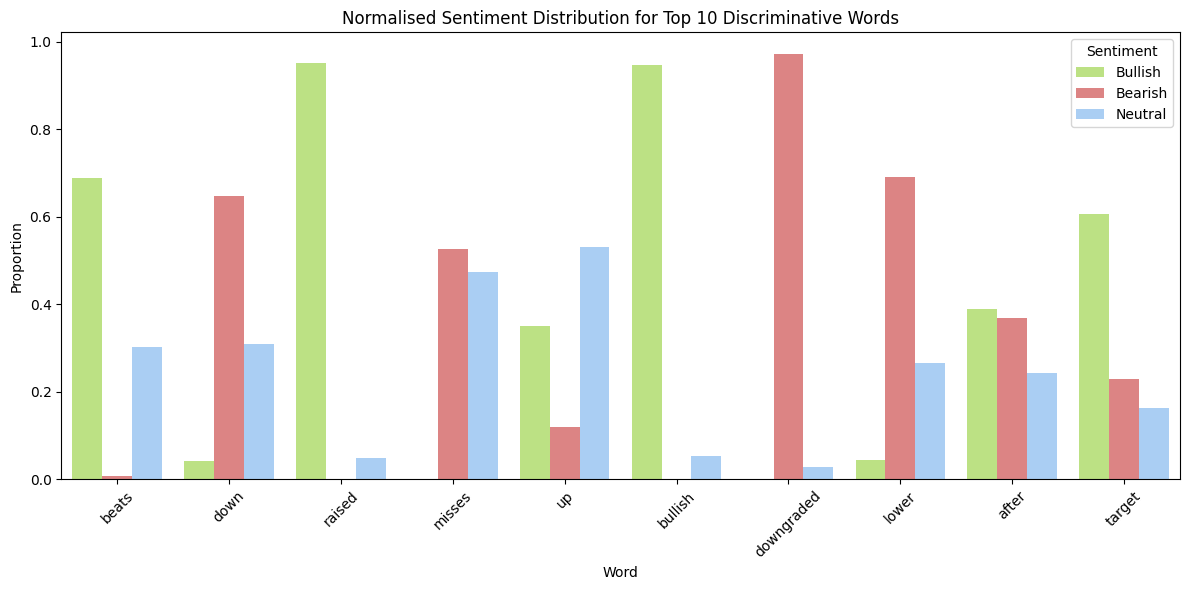

In [ ]:
data = {
    "Word": ["beats", "down", "raised", "misses", "up", "bullish", "downgraded", "lower", "after", "target"],
    "Bullish": [91, 10, 78, 0, 346, 18, 0, 3, 150, 108],
    "Bearish": [1, 153, 0, 50, 119, 0, 36, 47, 142, 41],
    "Neutral": [40, 73, 4, 45, 525, 1, 1, 18, 94, 29]
}

df = pd.DataFrame(data)

df_norm = df.copy()
df_norm[["Bullish", "Bearish", "Neutral"]] = df_norm[["Bullish", "Bearish", "Neutral"]].div(
    df_norm[["Bullish", "Bearish", "Neutral"]].sum(axis=1), axis=0
)

df_long_norm = df_norm.melt(id_vars="Word", var_name="Sentiment", value_name="Proportion")

plt.figure(figsize=(12, 6))
sns.barplot(data=df_long_norm, x="Word", y="Proportion", hue="Sentiment", palette=["#bff174", "#eb7575", "#9eceff"])

plt.title("Normalised Sentiment Distribution for Top 10 Discriminative Words")
plt.xticks(rotation=45)
plt.ylabel("Proportion")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


# 2. Data Preprocessing

> We implemented several data preprocessing step, but not all of them were applied together at the same time. Given that the best preprocessing used will depend on the type of feature extraction that we use, in this section we will simply present what it would look like if we did apply all the different preprocessing steps.

> The preprocessing used was:
> - Regular expression substitution;
> - Stop word removal, with the exception of retained “down”, “up”, “above”, “below”, “not”, “no”, “but”, “don’t”, “doesn’t”, “doesn’”;
> - Punctuation removal except for exclamation marks;
> - Lowercasing;
> - Stemming vs. Lemmatization

In [62]:
regex_flags = create_regex_flag() #All true
regex_flags

{'$words mentions': True,
 '$numbers mentions': True,
 'Negative number mentions': True,
 'Positive percentage mentions': True,
 'Dates mentions': True,
 'Positive number mentions': True,
 'Links mentions': True,
 'Unicode mentions': True,
 'User mentions (@user)': True,
 'Hashtag mentions (#hashtag)': True,
 'Multi-exclamation mentions': True,
 'Multi-stop mentions': True,
 'Marketscreener mentions': True}

In [63]:
df_train['preprocessed_text'] = df_train["text"].apply(
    lambda x: processing_text(
        x,
        remove_stopwords=True,
        stem=False,
        lemmatize=False,
        regex=True,
        re_expressions=pattern_meaning_dict,
        substitution=pattern_substitution_dict,
        lowercase=True,
        remove_punct=True,
        regex_flags=regex_flags
    )
)

In [64]:
df_train.head()

,text,label,named_label,word_count,language,preprocessed_text
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,0,Bearish (0),10,en,stock jpmorgan reels expectations beyond meat
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,0,Bearish (0),14,en,stock stock nomura points bookings weakness carnival royal caribbean
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",0,Bearish (0),14,en,stock cemex cut credit suisse jp morgan weak building outlook
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,0,Bearish (0),7,en,stock btig research cuts neutral
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,0,Bearish (0),10,da,stock funko slides piper jaffray pt cut


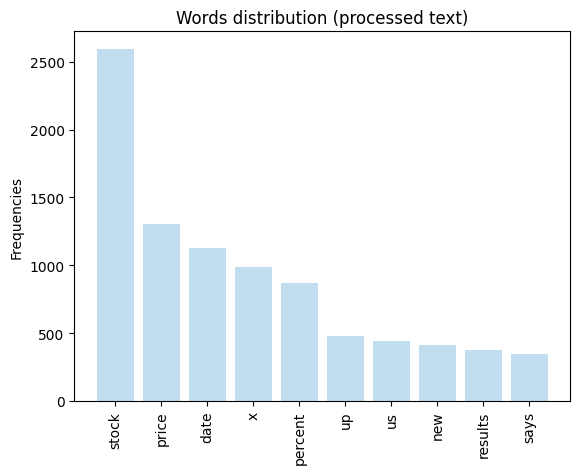

In [65]:
all_words = ' '.join(df_train['preprocessed_text'].fillna('')).lower().split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5, color='#87bde1')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words distribution (processed text)')
plt.xticks(rotation=90)
plt.show()

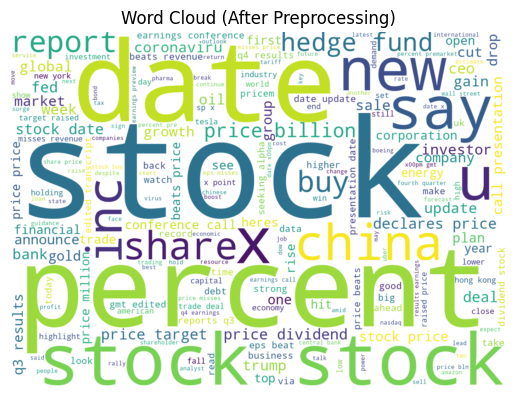

In [68]:
raw_text = ' '.join(df_train['preprocessed_text'].fillna('')).lower()
raw_wc = WordCloud(width=1400, height=1000, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (After Preprocessing)')
plt.show()

C:\Users\ritaw\AppData\Local\Temp\ipykernel_19136\2967268986.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_df, x="count", y="bigram", palette=sns.color_palette("Set2", 10))


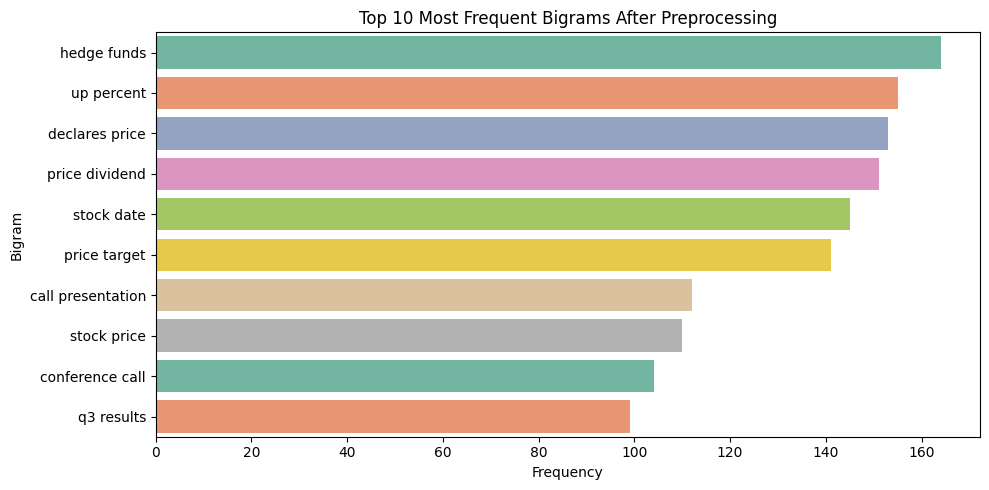

In [69]:
top_tweet_bigrams = get_top_tweet_bigrams(df_train['preprocessed_text'])[2:12]
x, y = map(list, zip(*top_tweet_bigrams))
bigram_df = pd.DataFrame({"bigram": x, "count": y})

plt.figure(figsize=(10, 5))
sns.barplot(data=bigram_df, x="count", y="bigram", palette=sns.color_palette("Set2", 10))
plt.title("Top 10 Most Frequent Bigrams After Preprocessing")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()